# 1. Import Required Packages

In [ ]:
import pandas as pd
import numpy as np
import re
import unicodedata
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import string
import spacy

In [ ]:
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 58.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Download necessary resources
nltk.download('stopwords')

# Load stopwords
french_stopwords = set(stopwords.words('french'))
arabic_stopwords = set(stopwords.words('arabic'))

# Manually extend Arabic stopword list
extra_stopwords = {"و", "في", "من", "على", "الى", "أن", "عن", "ما", "لا", "لم", "لن", "قد", "هذا", "هذه", "ذلك", "تلك", "كل", "هكذا"}
arabic_stopwords.update(extra_stopwords)

# Manually add common contractions and short words
french_stopwords.update({"d'", "l'", "m'", "n'", "s'", "t'", "qu'", "c'", "j'", "de", "des", "du", "la", "le", "les"})

# Load NLP models
nlp_fr = spacy.load("fr_core_news_sm")  # French lemmatization

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 2. Load Dataset

In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = "/content/drive/My Drive/hackathon1/activities-hackathon/DATASET SPLIT/proposition_FA.xlsx"
df = pd.read_excel(file_path)

# Display missing values
print("Missing Values per Column:\n", df.isnull().sum())

# Show rows with missing values
df_missing = df[df.isnull().any(axis=1)]
print("\nRows with Missing Values:\n", df_missing)

# Fill missing values with empty string
df.fillna("", inplace=True)

Missing Values per Column:
 code_pro        0
wilaya         13
field          71
activity        0
description     0
dtype: int64

Rows with Missing Values:
      code_pro      wilaya                   field  \
28   TZ5ALEHA       Blida                     NaN   
32   AML3XLER     Algiers                     NaN   
36   VNRHZ261  Tissemsilt                     NaN   
47   Q5ULG984     Tlemcen                     NaN   
55   UFWF4RLT        Oran                     NaN   
..        ...         ...                     ...   
656  2NFLCV7V        Oran                     NaN   
678  GAHK82PD        Oran                     NaN   
685  2EE2XL31       Setif                     NaN   
686  DH9DCWKM       Medea                     NaN   
688  9KEGY8SK         NaN  Services à la personne   

                                              activity  \
28                                             scripts   
32                        orthophonie  et  psychologie   
36   organisation des fêtes cu

#  3. Define Text Preprocessing Functions

In [ ]:
def preprocess_french_text(text):
    """Normalize, remove stopwords (including contractions), and lemmatize French text."""

    if not text or text.strip() == "":  # Handle empty text
        return ""

    text = text.lower()  # Convert to lowercase
    text = unidecode(text)  # Remove accents

    # Replace contractions explicitly before tokenization
    text = re.sub(r"\b(d'|l'|m'|n'|s'|t'|qu'|c'|j')", "", text)  # Remove contractions
    text = re.sub(r"\b(de|des|du|la|le|les)\b", "", text)  # Remove "de", "du", "des", etc.

    text = re.sub(r"[^\w\s]", '', text)  # Remove punctuation
    text = re.sub(r"\d+", '', text)  # Remove digits
    text = re.sub(r"\s+", ' ', text).strip()  # Remove extra spaces

    # Tokenize and remove stopwords
    words = text.split()
    words = [word for word in words if word not in french_stopwords]

    if not words:  # If all words are stopwords, return empty string
        return ""

    # Convert back to string for lemmatization
    doc = nlp_fr(" ".join(words))

    # Return lemmatized words
    return ' '.join([token.lemma_.lower() for token in doc])

In [ ]:
def preprocess_arabic_text(text):
    """Remove Arabic stopwords, handle 'و', remove 'ال' (definite article), and clean text."""

    text = re.sub(r'[\u064B-\u0652]', '', text)  # Remove Arabic diacritics (Tashkeel)
    text = re.sub(r'[^\u0600-\u06FF\s]', '', text)  # Keep only Arabic characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces

    words = text.split()

    # Remove "و" if it appears at the beginning of a word
    words = [word[1:] if word.startswith("و") else word for word in words]

    # Remove the Arabic definite article "ال" if it's at the start of a word
    words = [word[2:] if word.startswith("ال") and len(word) > 2 else word for word in words]

    # Remove standalone "و" and other stopwords
    words = [word for word in words if word not in arabic_stopwords]

    return ' '.join(words)

In [ ]:
def is_arabic(text):
    """Check if the text contains Arabic characters."""
    return any("\u0600" <= char <= "\u06FF" for char in str(text))

def detect_and_preprocess(text):
    """Detect language and apply the appropriate preprocessing function."""
    if not text or text.strip() == "":
        return text

    try:
        if is_arabic(text):
            return preprocess_arabic_text(text)  # Arabic detected
        return preprocess_french_text(text)
    except Exception as e:
        print(f"Language detection error: {e}")
        return text  # Return the original text if detection fails

# 4. Apply Preprocessing

In [ ]:
# Apply preprocessing to both "activity" and "description"
df['processed_activity'] = df['activity'].apply(detect_and_preprocess)
df['processed_description'] = df['description'].apply(detect_and_preprocess)

print("Text Preprocessing Completed Successfully!")

Text Preprocessing Completed Successfully!


In [ ]:
# Show the first few rows
df.head()

,code_pro,wilaya,field,activity,description,processed_activity,processed_description
0,P4RXBDCK,Algiers,Services à la personne,Repartion chod et froid,تصليح وتركيب اجهزة التبريد والتكييف,repartion chod froid,تصليح تركيب اجهزة تبريد تكييف
1,E82UPUW5,Algiers,Services à la personne,Modification des phares automobiles,تعديل أضواء السيارات,modification phare automobile,تعديل أضواء سيارات
2,WB9MVK64,Boumerdes,Services numériques et activités connexes,plateforme micro service,امتلاك منصة اعمال حرة مثل فايفر هيا انك تفت من...,plateform micro service,امتلاك منصة اعمال حرة فايفر انك تفت منصو تعطي ...
3,Y3MQPYRH,Annaba,Services à la personne,Transport,نقل البضائع,transport,نقل بضائع
4,3HZVMU8K,Algiers,Services à la personne,سياقة درجة نارية,Easy & Speed,سياقة درجة نارية,easy speed


In [ ]:
# Define new file path for the cleaned dataset
cleaned_file_path = "/content/drive/My Drive/hackathon1/activities-hackathon/DATASET SPLIT/proposition_FA_cleaned.xlsx"

# Save the modified dataset as a new file
df.to_excel(cleaned_file_path, index=False)

print("Cleaned dataset saved successfully as proposition_FA_cleaned.xlsx")

Cleaned dataset saved successfully as proposition_FA_cleaned.xlsx


# 5. Embedding Matching

## Step 1: Load Models & Preprocess Official Activities

In [ ]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load datasets
official_file_path = "/content/drive/My Drive/hackathon1/activities-hackathon/activity_list.xlsx"
input_file_path = "/content/drive/My Drive/hackathon1/activities-hackathon/DATASET SPLIT/proposition_FA_cleaned.xlsx"

df_official = pd.read_excel(official_file_path)
df_ff = pd.read_excel(input_file_path)

# Ensure columns are treated as strings
df_official[['name_activity', 'ar_name_activity']] = df_official[['name_activity', 'ar_name_activity']].astype(str)
df_ff['processed_activity'] = df_ff['processed_activity'].astype(str)


##  Step 2: Generate Embeddings

In [ ]:
# Load sentence embedding model (multilingual)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('Alibaba-NLP/gte-multilingual-base', device=device, trust_remote_code=True)

# Generate embeddings for official activities (French + Arabic)
df_official['combined_activity'] = df_official['name_activity'] + " | " + df_official['ar_name_activity']
df_official['activity_embeddings'] = list(model.encode(df_official['combined_activity'].tolist(), convert_to_numpy=True))

# Generate embeddings for input activities
df_ff['concent'] = df_ff['processed_activity'] + " " +  df_ff['processed_description']
df_ff['activity_embeddings'] = list(model.encode(df_ff['concent'].tolist(), convert_to_numpy=True))

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: {'classifier.bias', 'classifier.weight'}
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Step 3: Compute Cosine Similarity & Find Matches

In [ ]:
def find_best_embedding_match(activity_embedding, official_embeddings, official_names, threshold=0.7):
    similarities = cosine_similarity([activity_embedding], official_embeddings)[0]
    best_index = np.argmax(similarities)
    best_score = similarities[best_index]

    if best_score >= threshold:
        return official_names[best_index], best_score
    return None, None  # No strong match found

# Prepare official embeddings
official_embeddings = np.vstack(df_official['activity_embeddings'].to_numpy())
official_names = df_official['combined_activity'].tolist()

# Apply matching and store results
matched_activities = []
for idx, row in df_ff.iterrows():
    best_match, best_score = find_best_embedding_match(row['activity_embeddings'], official_embeddings, official_names)
    if best_match:
        matched_activities.append((row['concent'], best_match, best_score * 100))  # Convert score to %

# Store results in DataFrame
redundant_activities = pd.DataFrame(matched_activities, columns=["Proposed Activity", "Best Matched Official Activity", "Best Score (%)"])

# Display results
print(f"Number of redundant activities found via embeddings: {len(redundant_activities)}\n")
for _, row in redundant_activities.iterrows():
    print(f"Proposed Activity: {row['Proposed Activity']}")
    print(f"Best Matched Official Activity: {row['Best Matched Official Activity']}")
    print(f"Similarity Score: {row['Best Score (%)']:.2f}%")  # Display score with 2 decimal places
    print("-" * 50)

print(f"Remaining activities after removing embedding-based redundant ones: {df_ff.shape[0] - len(redundant_activities)}")

Number of redundant activities found via embeddings: 274

Proposed Activity: repartion chod froid تصليح تركيب اجهزة تبريد تكييف
Best Matched Official Activity: Dépanneur en installations de froid et climatisation | مصلح في تركيب التبريد والتكييف
Similarity Score: 79.99%
--------------------------------------------------
Proposed Activity: maintenance electricite general صيانة أعطال كهربائية منزلية بشتى انواعها
Best Matched Official Activity: Electrotechnicien de maintenance | كهروميكانيكي في الصيانة
Similarity Score: 78.56%
--------------------------------------------------
Proposed Activity: تكييف  تبريد montage reparation climatisation general
Best Matched Official Activity: Monteur-dépanneur en installations de froid et climatisation | مركب مصلح في تركيب التبريد والتكييف
Similarity Score: 78.84%
--------------------------------------------------
Proposed Activity: guide touristique انا نخدم محتوى إنستقرام  يجوني ناس حابين يحوسو معايا  نكون مرشد تاعهم تسما جاوني اونلاين  نكون مرشدهم


In [ ]:
df_ff

,code_pro,wilaya,field,activity,description,processed_activity,processed_description,concent,activity_embeddings
0,P4RXBDCK,Algiers,Services à la personne,Repartion chod et froid,تصليح وتركيب اجهزة التبريد والتكييف,repartion chod froid,تصليح تركيب اجهزة تبريد تكييف,repartion chod froid تصليح تركيب اجهزة تبريد ت...,"[-0.054328166, 0.058722124, -0.002953348, 0.02..."
1,E82UPUW5,Algiers,Services à la personne,Modification des phares automobiles,تعديل أضواء السيارات,modification phare automobile,تعديل أضواء سيارات,modification phare automobile تعديل أضواء سيارات,"[-0.02653488, 0.046322722, 0.026649175, 0.0618..."
2,WB9MVK64,Boumerdes,Services numériques et activités connexes,plateforme micro service,امتلاك منصة اعمال حرة مثل فايفر هيا انك تفت من...,plateform micro service,امتلاك منصة اعمال حرة فايفر انك تفت منصو تعطي ...,plateform micro service امتلاك منصة اعمال حرة ...,"[-0.07492095, -0.009832662, -0.0041158805, 0.0..."
3,Y3MQPYRH,Annaba,Services à la personne,Transport,نقل البضائع,transport,نقل بضائع,transport نقل بضائع,"[-0.06079207, 0.056602094, -0.038393326, 0.084..."
4,3HZVMU8K,Algiers,Services à la personne,سياقة درجة نارية,Easy & Speed,سياقة درجة نارية,easy speed,سياقة درجة نارية easy speed,"[-0.02011656, 0.09610175, -0.012540751, 0.0146..."
...,...,...,...,...,...,...,...,...,...
695,82NWMCYR,Aïn Temouchent,Services numériques et activités connexes,Commerce électronique,تجارة إلكترونية دولية ومحلية والتبادل العملاة ...,commerce electroniqu,تجارة إلكترونية دولية محلية تبادل عملاة رقمية ...,commerce electroniqu تجارة إلكترونية دولية محل...,"[-0.1150746, 0.019159397, 0.04730062, 0.054027..."
696,WUYWYGX1,Tizi Ouzou,Services numériques et activités connexes,Livreur avec voiture,عامل لدى شركة توصيل بسيارة عائلية خاصة,livreur voiture,عامل شركة توصيل بسيارة عائلية,livreur voiture عامل شركة توصيل بسيارة عائلية,"[-0.07475421, 0.027418282, 0.011056075, 0.0929..."
697,P5NLQNTW,Ouargla,Services aux entreprises,Conseille juridique,مستار في قانون العمل,conseill juridique,مستار قانون عمل,conseill juridique مستار قانون عمل,"[-0.06403054, 0.01656888, -0.06169304, -0.0181..."
698,EVQHHF1B,Algiers,Services à la personne,Décoration travaux maison,مختص في ديكور المنزلي,decoration traval maison,مختص ديكور منزلي,decoration traval maison مختص ديكور منزلي,"[-0.06823866, 0.06001706, -0.016355231, 0.0065..."


In [ ]:
df_ff = df_ff[~df_ff['concent'].isin(redundant_activities["Proposed Activity"])].copy()
df_ff = df_ff[['code_pro', 'wilaya', 'field', 'activity', 'description', 'processed_activity', 'processed_description', 'activity_embeddings']]
df_ff

,code_pro,wilaya,field,activity,description,processed_activity,processed_description,activity_embeddings
1,E82UPUW5,Algiers,Services à la personne,Modification des phares automobiles,تعديل أضواء السيارات,modification phare automobile,تعديل أضواء سيارات,"[-0.02653488, 0.046322722, 0.026649175, 0.0618..."
2,WB9MVK64,Boumerdes,Services numériques et activités connexes,plateforme micro service,امتلاك منصة اعمال حرة مثل فايفر هيا انك تفت من...,plateform micro service,امتلاك منصة اعمال حرة فايفر انك تفت منصو تعطي ...,"[-0.07492095, -0.009832662, -0.0041158805, 0.0..."
3,Y3MQPYRH,Annaba,Services à la personne,Transport,نقل البضائع,transport,نقل بضائع,"[-0.06079207, 0.056602094, -0.038393326, 0.084..."
4,3HZVMU8K,Algiers,Services à la personne,سياقة درجة نارية,Easy & Speed,سياقة درجة نارية,easy speed,"[-0.02011656, 0.09610175, -0.012540751, 0.0146..."
9,V2Q1QK12,Algiers,Services aux entreprises,أعمال تهيئة,Travaux réaménagement d'entreprises,أعمال تهيئة,travail reamenagement entreprendre,"[-0.056628525, 0.0053413673, -0.046166126, 0.0..."
...,...,...,...,...,...,...,...,...
692,ANEVZK21,Algiers,Services à la personne,الحداد,Forgeron,حداد,forgeron,"[-0.03097203, 0.099524416, -0.0060311095, 0.05..."
693,45BCEMVR,Algiers,Services à la personne,شركة التنظيف,Une entreprise de nettoyage propose en général...,شركة تنظيف,entreprise nettoyage proposer general offrir v...,"[-0.10042391, 0.02245382, 0.0042519267, 0.0379..."
694,8K4E5DZR,Msila,Prestations à domicile,Planner design,مشروعي عبارة عن صناعة دفاتر مخصصة كدفاتر رمضان...,planner design,مشروعي عبارة صناعة دفاتر مخصصة كدفاتر رمضان ،ت...,"[-0.041972093, -0.0033079088, -0.05465775, -0...."
697,P5NLQNTW,Ouargla,Services aux entreprises,Conseille juridique,مستار في قانون العمل,conseill juridique,مستار قانون عمل,"[-0.06403054, 0.01656888, -0.06169304, -0.0181..."


In [ ]:
# Save cleaned dataset
output_file_path = "/content/drive/My Drive/hackathon1/activities-hackathon/proposition_FA_embedd.xlsx"
df_ff.to_excel(output_file_path, index=False)

print(f"Fuzzy matching completed. Results saved to {output_file_path}")

Fuzzy matching completed. Results saved to /content/drive/My Drive/hackathon1/activities-hackathon/proposition_FA_embedd.xlsx


# 6. Remove Commercial Activities

In [ ]:
import pandas as pd
import numpy as np
import torch
import ast
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load datasets
input_file_path =  "/content/drive/My Drive/hackathon1/activities-hackathon/proposition_FA_embedd.xlsx"
df_ff = pd.read_excel(input_file_path)

# Exclude traditional commercial activities (French + Arabic)
commercial_keywords = [
    # (French)
    "restaurant", "vente", "achat", "café", "fast food", "boucherie", "poissonnerie", "téléphone",
    "bijouterie", "magasin", "boutique", "fournisseur", "détaillant", "grossiste", "revendeur",
    "importateur", "exportateur", "franchise", "vendeur", "commerçant", "négoce", "dépôt vente",
    "magasin alimentaire", "produits alimentaires", "produits de consommation", "liquidation",
    "bazar", "marché", "vente de voitures", "agents commerciaux", "services de livraison",
    "construction", "matériel de construction", "équipement industriel", "téléphonie mobile", "réparation",
    "location", "distribution", "importation", "commerce de détail", "distributeur", "commerçant de proximité",
    "agricole", "produits agricoles", "alimentation générale", "commerçant ambulant", "transports", "kms", "kiosque"


    # (Arabic)
    "مطعم", "بيع", "شراء", "مقهى", "وجبات سريعة", "جزارة", "سمك", "هاتف", "مجوهرات", "متجر", "دكان",
    "مورد", "تاجر تجزئة", "تاجر جملة", "بائع", "مستورد", "مُصدر", "امتياز", "بائع", "تاجر", "تجارة",
    "بيع بالتجزئة", "منتجات غذائية", "منتجات استهلاكية", "تصفية", "بازار", "سوق", "بيع السيارات",
    "وكلاء تجاريين", "خدمات التوصيل", "إنشاء", "معدات البناء", "تجهيزات صناعية", "هواتف محمولة",
    "صيانة", "إيجار", "توزيع", "استيراد", "تجارة التجزئة", "موزع", "تاجر محلي", "زراعي", "منتجات زراعية",
    "تجارة عامة", "تاجر متجول", "نقل"
]

# Allowed intermediary and e-commerce activities (French + Arabic)
intermediary_keywords = [
    # French
    "e-commerce", "plateforme de vente", "e-shop", "site marchand", "marketplace", "dropshipping",
    "affiliation", "vente en ligne", "webshop", "commerce en ligne", "commerce virtuel", "commerce digital",
    "boutique en ligne", "vente sur internet", "e-business", "business en ligne", "auto-entrepreneur",
    "micro-entreprise", "fournisseur e-commerce", "vente à distance", "services digitaux",
    "commerce électronique", "start-up", "startup numérique", "entrepreneur digital", "services de paiement",
    "paiement en ligne", "agent commercial", "courtier", "publicité en ligne", "consultant digital",
    "services en ligne", "freelance", "plateforme de freelancing", "commercialisation", "digital marketing",
    "plateforme B2B", "plateforme B2C", "vente indirecte", "réseau de distribution", "fournisseur B2B",
    "gestion e-commerce", "boutique virtuelle", "stratégie digitale", "entreprise numérique"

    # Arabic
    "تجارة إلكترونية", "متجر إلكتروني", "محل إلكتروني", "موقع تجاري", "سوق إلكتروني", "تجارة عبر الإنترنت",
    "متجر رقمي", "تسوق أونلاين", "بيع عبر الإنترنت", "شراء عبر الإنترنت", "خدمات الإنترنت",
    "دروبشيبينغ", "تسويق بالعمولة", "متجر على الإنترنت", "تجارة افتراضية", "تجارة رقمية", "تجارة عن بعد",
    "مورد تجارة إلكترونية", "شركة ناشئة", "ريادي رقمي", "ريادة أعمال رقمية", "مزود خدمات تجارية",
    "بيع بالجملة أونلاين", "وكيل مبيعات", "سمسار إلكتروني", "تسويق إلكتروني", "خدمات الدفع",
    "خدمات مالية", "إعلانات عبر الإنترنت", "إعلانات رقمية", "مستشار رقمي", "حملات إعلانية رقمية",
    "استراتيجيات تسويق رقمي", "منصة بيع إلكترونية", "منصة إعلانات", "تسويق بالعمولة",
    "وكيل تجاري رقمي", "خدمات التوصيل الرقمية", "بيع بالتجزئة على الإنترنت", "شبكة توزيع",
    "تاجر رقمي", "تاجر إلكتروني", "تاجر أونلاين", "تاجر جملة", "تاجر تجزئة", "تاجر مستقل",
    "تاجر على الإنترنت", "تاجر إلكتروني مستقل", "تاجر منصات رقمية", "تاجر بيع بالتجزئة",
    "تاجر بيع بالجملة", "تاجر استيراد وتصدير"
]


In [ ]:
# Step 1: Tag intermediary activities (but keep them)
df_ff['is_intermediary'] = df_ff.apply(
    lambda row: any(keyword in str(row['processed_activity']) or keyword in str(row['processed_description'])
                   for keyword in intermediary_keywords), axis=1
)

In [ ]:
# Step 2: Identify strictly commercial activities (excluding intermediary ones)
df_ff['is_commercial'] = df_ff.apply(
    lambda row: any(kw in str(row['processed_activity']) or kw in str(row['processed_description'])
                    for kw in commercial_keywords) and not row['is_intermediary'], axis=1
)

# Count before filtering
total_activities = df_ff.shape[0]
commercial_activities = df_ff[df_ff['is_commercial']].shape[0]
intermediary_activities = df_ff[df_ff['is_intermediary']].shape[0]

In [ ]:
# Count after filtering
non_commercial_activities = df_ff.shape[0]

# Print summary
print(f"Total activities before filtering: {total_activities}")
print(f"Identified intermediary activities (kept): {intermediary_activities}")
print(f"Strictly commercial activities to be removed: {commercial_activities}")
print(f"Final non-commercial activities: {non_commercial_activities}")

Total activities before filtering: 426
Identified intermediary activities (kept): 3
Strictly commercial activities to be removed: 83
Final non-commercial activities: 426


In [ ]:
df_commercial_subset = df_ff[df_ff['is_commercial']].copy()
df_commercial_subset

,code_pro,wilaya,field,activity,description,processed_activity,processed_description,activity_embeddings,is_intermediary,is_commercial
2,Y3MQPYRH,Annaba,Services à la personne,Transport,نقل البضائع,transport,نقل بضائع,[-6.07920699e-02 5.66020943e-02 -3.83933261e-...,False,True
8,KPG6YEGU,Algiers,Prestations à domicile,La plombier général et chaudière,نشاط متنقل,plombier general chaudiere,نشاط متنقل,[-9.27781835e-02 7.10881175e-03 -1.47540299e-...,False,True
10,XZ69KXYG,Tlemcen,Services aux entreprises,International sourcing agent,السلام عليكم ...,international sourcing agent,سلام عليكم يعتبر هدا مجال اكتر مجالات شيوعا عا...,[-6.65116087e-02 5.40670287e-03 -1.05707636e-...,False,True
16,R8NSQZK4,Algiers,Services à la personne,Wanted vetmeant,بيع ثياب نساء رجال أطفال مستوردة,wanted vetmeer,بيع ثياب نساء رجال أطفال مستوردة,[-9.25583094e-02 4.98749465e-02 1.03221415e-...,False,True
27,86PBSRGP,Boumerdes,Services à la personne,Promoteur immobilier,تقديم دراسات و مخططات في مجال البناء والعقار ...,promoteur immobilier,تقديم دراسات مخططات مجال بناء عقار قناعة زبون...,[-5.01299240e-02 -6.19735606e-02 -5.12988605e-...,False,True
...,...,...,...,...,...,...,...,...,...,...
399,XF1S52LQ,Annaba,Services numériques et activités connexes,Trading,التداول سواء كان ( عملات رقمية ، سوق الفوركس ،...,trading,تداول سواء عملات رقمية ، سوق فوركس ، سلع ، منتجات,[-9.56071392e-02 -2.77238470e-02 3.41007635e-...,False,True
404,NDT5FN1Z,Boumerdes,Services aux entreprises,Location camion grue et transport marchandises,كراء الشاحنة ونقل البضائع,location camion gru transport marchandise,كراء شاحنة نقل بضائع,[-7.09336102e-02 4.04556394e-02 1.18099444e-...,False,True
414,KUNUTT17,Boumerdes,"Conseil, Expertise et formation",مقاول,Le domaine de construction,مقاول,domaine construction,[-4.70750891e-02 2.60640569e-02 -2.87558716e-...,False,True
418,XLB42RRA,Oran,Services à la personne,Livraison dès gâteau,توزيع الحلويات,livraison gateau,توزيع حلويات,[-1.33990377e-01 6.99543804e-02 -6.84303120e-...,False,True


In [ ]:
# Load sentence embedding model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('Alibaba-NLP/gte-multilingual-base', device=device, trust_remote_code=True)

# Generate embeddings for activity descriptions
df_ff['combined_text'] = df_ff['processed_activity']  + " " + df_ff['processed_description']
df_ff['activity_embeddings'] = list(model.encode(df_ff['combined_text'].tolist(), convert_to_numpy=True))

# Create embeddings for commercial and intermediary keywords
df_commercial = pd.DataFrame({'keyword': commercial_keywords})
df_commercial['embedding'] = df_commercial['keyword'].apply(lambda x: model.encode(x, convert_to_numpy=True))

df_intermediary = pd.DataFrame({'keyword': intermediary_keywords})
df_intermediary['embedding'] = df_intermediary['keyword'].apply(lambda x: model.encode(x, convert_to_numpy=True))


Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: {'classifier.bias', 'classifier.weight'}
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Filter only commercial activities for embedding comparison
df_commercial_subset = df_ff[df_ff['is_commercial']].copy()

# Ensure embeddings are stored as NumPy arrays
df_commercial_subset['activity_embeddings'] = df_commercial_subset['activity_embeddings'].apply(
    lambda x: np.array(ast.literal_eval(x)) if isinstance(x, str) else x
)
# Function to classify activities based on embeddings
def classify_activity(activity_embedding, commercial_embeddings, intermediary_embeddings):
    commercial_sim = cosine_similarity([activity_embedding], commercial_embeddings.tolist()).max()
    intermediary_sim = cosine_similarity([activity_embedding], intermediary_embeddings.tolist()).max()

    return commercial_sim > intermediary_sim  # Mark as commercial if similarity is higher


# Apply classification only on commercial subset
df_commercial_subset['is_commercial_embedded'] = df_commercial_subset['activity_embeddings'].apply(
    lambda emb: classify_activity(emb, df_commercial['embedding'], df_intermediary['embedding'])
)

# Merge results back to main dataset
df_ff.loc[df_ff['is_commercial'], 'is_commercial_embedded'] = df_commercial_subset['is_commercial_embedded']
df_ff['is_commercial_embedded'] = df_ff['is_commercial_embedded'].fillna(False)  # Replace NaN with False

# Print results
print(f"Total commercial activities confirmed by embeddings: {df_ff[df_ff['is_commercial_embedded']].shape[0]}")
print(f"Total activities after embedding comparison: {df_ff[df_ff['is_commercial_embedded'] == False].shape[0]}")


Total commercial activities confirmed by embeddings: 65
Total activities after embedding comparison: 361


<ipython-input-47-b3997f9bd899>:23: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_ff['is_commercial_embedded'] = df_ff['is_commercial_embedded'].fillna(False)  # Replace NaN with False


In [ ]:
df_ff[df_ff['is_commercial_embedded']]

,code_pro,wilaya,field,activity,description,processed_activity,processed_description,activity_embeddings,is_intermediary,is_commercial,combined_text,is_commercial_embedded
2,Y3MQPYRH,Annaba,Services à la personne,Transport,نقل البضائع,transport,نقل بضائع,"[-0.06079207, 0.056602094, -0.038393326, 0.084...",False,True,transport نقل بضائع,True
8,KPG6YEGU,Algiers,Prestations à domicile,La plombier général et chaudière,نشاط متنقل,plombier general chaudiere,نشاط متنقل,"[-0.09277818, 0.0071088118, -0.01475403, 0.055...",False,True,plombier general chaudiere نشاط متنقل,True
16,R8NSQZK4,Algiers,Services à la personne,Wanted vetmeant,بيع ثياب نساء رجال أطفال مستوردة,wanted vetmeer,بيع ثياب نساء رجال أطفال مستوردة,"[-0.09255831, 0.049874946, 0.010322141, 0.0455...",False,True,wanted vetmeer بيع ثياب نساء رجال أطفال مستوردة,True
28,PKZ3GHY8,Blida,Services numériques et activités connexes,Livreur des produits d'emballage,بائع متنقل لإيصال أدوات التغليف المختلفة للمطا...,livreur produit emballag,بائع متنقل لإيصال أدوات تغليف مختلفة للمطاعم ...,"[-0.06288802, 0.043020733, -0.01209128, 0.0566...",False,True,livreur produit emballag بائع متنقل لإيصال أدو...,True
36,3N54T5LW,Algiers,Services aux entreprises,VENTE ET VERFCATION ET RECHARGE MATERILD D INC...,صيانة وتعبئة قروراة الاطفاء وانظمة ضذالحريق,vente verfcation recharg materild incendie,صيانة تعبئة قروراة اطفاء انظمة ضذالحريق,"[-0.109072864, -0.006628449, -0.0037070324, 0....",False,True,vente verfcation recharg materild incendie صيا...,True
...,...,...,...,...,...,...,...,...,...,...,...,...
396,WB78R3R6,Oran,Services à la personne,Fruits,بيع الفواكه,fruit,بيع فواكه,"[-0.013860157, 0.0085732285, -0.077114485, 0.0...",False,True,fruit بيع فواكه,True
404,NDT5FN1Z,Boumerdes,Services aux entreprises,Location camion grue et transport marchandises,كراء الشاحنة ونقل البضائع,location camion gru transport marchandise,كراء شاحنة نقل بضائع,"[-0.07093361, 0.04045564, 0.0011809944, 0.1067...",False,True,location camion gru transport marchandise كراء...,True
414,KUNUTT17,Boumerdes,"Conseil, Expertise et formation",مقاول,Le domaine de construction,مقاول,domaine construction,"[-0.04707509, 0.026064057, -0.028755872, 0.078...",False,True,مقاول domaine construction,True
418,XLB42RRA,Oran,Services à la personne,Livraison dès gâteau,توزيع الحلويات,livraison gateau,توزيع حلويات,"[-0.13399038, 0.06995438, -0.06843031, 0.03669...",False,True,livraison gateau توزيع حلويات,True


In [ ]:
# Count before filtering
total_activities = df_ff.shape[0]
commercial_activities_embedded = df_ff[df_ff['is_commercial_embedded']].shape[0]

# Count after filtering
non_commercial_activities_embedded = df_ff.shape[0] - commercial_activities_embedded

# Print summary
print(f"Total activities before filtering: {total_activities}")
print(f"Strictly commercial activities removed: {commercial_activities_embedded}")
print(f"Final non-commercial activities: {non_commercial_activities_embedded}")

Total activities before filtering: 426
Strictly commercial activities removed: 65
Final non-commercial activities: 361


In [ ]:
# Filter out commercial activities
df_ff = df_ff[~df_ff['is_commercial_embedded']].copy()

In [ ]:
df_ff = df_ff[['code_pro', 'wilaya', 'field', 'activity', 'description', 'processed_activity','processed_description']]
df_ff

,code_pro,wilaya,field,activity,description,processed_activity,processed_description
0,E82UPUW5,Algiers,Services à la personne,Modification des phares automobiles,تعديل أضواء السيارات,modification phare automobile,تعديل أضواء سيارات
1,WB9MVK64,Boumerdes,Services numériques et activités connexes,plateforme micro service,امتلاك منصة اعمال حرة مثل فايفر هيا انك تفت من...,plateform micro service,امتلاك منصة اعمال حرة فايفر انك تفت منصو تعطي ...
3,3HZVMU8K,Algiers,Services à la personne,سياقة درجة نارية,Easy & Speed,سياقة درجة نارية,easy speed
4,V2Q1QK12,Algiers,Services aux entreprises,أعمال تهيئة,Travaux réaménagement d'entreprises,أعمال تهيئة,travail reamenagement entreprendre
5,H28MSCPQ,Msila,Services aux entreprises,Aluco bond,تحسين واجهات المصانع و الفنادق والمحلات بصفائح...,aluco bond,تحسين اجهات مصانع فنادق محلات بصفائح المنيوم ...
...,...,...,...,...,...,...,...
421,ANEVZK21,Algiers,Services à la personne,الحداد,Forgeron,حداد,forgeron
422,45BCEMVR,Algiers,Services à la personne,شركة التنظيف,Une entreprise de nettoyage propose en général...,شركة تنظيف,entreprise nettoyage proposer general offrir v...
423,8K4E5DZR,Msila,Prestations à domicile,Planner design,مشروعي عبارة عن صناعة دفاتر مخصصة كدفاتر رمضان...,planner design,مشروعي عبارة صناعة دفاتر مخصصة كدفاتر رمضان ،ت...
424,P5NLQNTW,Ouargla,Services aux entreprises,Conseille juridique,مستار في قانون العمل,conseill juridique,مستار قانون عمل


In [ ]:
# Save the cleaned dataset
output_file_path = "/content/drive/My Drive/hackathon1/activities-hackathon/DATASET SPLIT/proposition_FA_filtered_non_comm.xlsx"
df_ff.to_excel(output_file_path, index=False)

print(f"Filtered dataset saved: {df_ff.shape[0]} remaining activities.")

Filtered dataset saved: 361 remaining activities.


# 7. Clustering

In [ ]:
import pandas as pd
import numpy as np
import umap
import hdbscan
import torch
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
import re

# Load dataset
df = pd.read_excel("/content/drive/My Drive/hackathon1/activities-hackathon/DATASET SPLIT/proposition_FA_filtered_non_comm.xlsx")

# Load multilingual model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer("Alibaba-NLP/gte-multilingual-base", device=device, trust_remote_code=True)

# Generate embeddings
df["combined_text"] = df["processed_activity"] + " " + df["description"]
df["embeddings"] = df["combined_text"].apply(lambda x: model.encode(x, convert_to_numpy=True))

# Convert to matrix
embedding_matrix = np.vstack(df["embeddings"].values)

# Normalize embeddings
embedding_matrix = normalize(embedding_matrix)

print(f"Computed embeddings for {df.shape[0]} activities.")

Some weights of the model checkpoint at Alibaba-NLP/gte-multilingual-base were not used when initializing NewModel: {'classifier.weight', 'classifier.bias'}
- This IS expected if you are initializing NewModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing NewModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Computed embeddings for 361 activities.


In [ ]:
import umap

umap_reducer = umap.UMAP(n_neighbors=20, n_components=5, metric='cosine', random_state=42)
umap_embeddings = umap_reducer.fit_transform(embedding_matrix)

# Reduce to 2D for visualization
umap_2d = umap.UMAP(n_neighbors=20, n_components=2, metric='cosine', random_state=42)
umap_2d_embeddings = umap_2d.fit_transform(embedding_matrix)

print("UMAP dimensionality reduction completed.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP dimensionality reduction completed.


In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=2, metric='euclidean', prediction_data=True)
df["cluster"] = clusterer.fit_predict(umap_embeddings)

# Check cluster distribution
print(f"Clusters found: {df['cluster'].nunique() - (1 if -1 in df['cluster'] else 0)}")
print(f"Noise Points: {list(df['cluster']).count(-1)}")

Clusters found: 16
Noise Points: 27


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


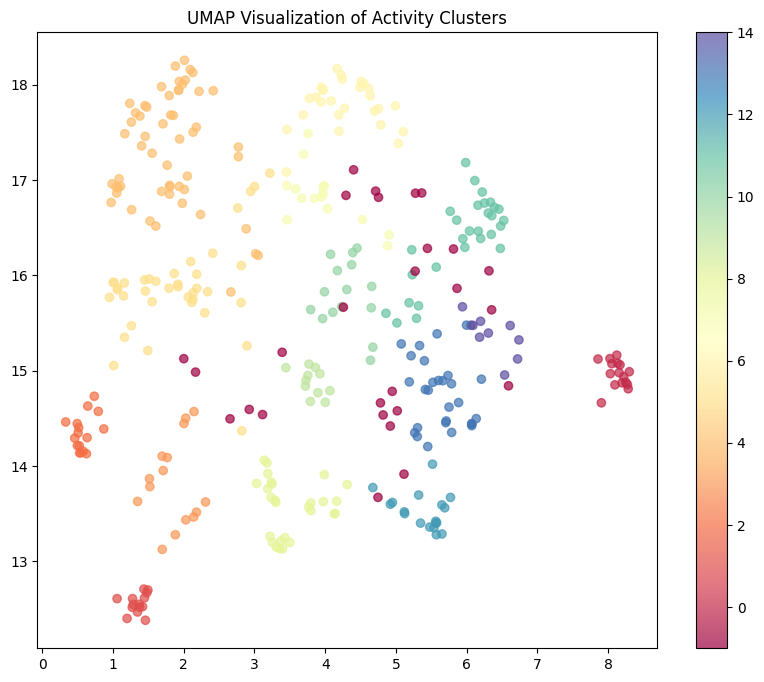

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_2d_embeddings[:, 0], umap_2d_embeddings[:, 1], c=df["cluster"], cmap='Spectral', alpha=0.7)
plt.colorbar(scatter)
plt.title("UMAP Visualization of Activity Clusters")
plt.show()

In [ ]:
# Fix: Ensure embeddings are properly formatted
def clean_embedding(embedding_str):
    try:
        if not isinstance(embedding_str, str):
            return np.zeros(768)  # Default zero vector if missing

        # Fix incorrect formatting
        embedding_str = re.sub(r'\s+', ',', embedding_str)
        embedding_str = embedding_str.replace("[,", "[").replace(",]", "]")
        embedding_str = embedding_str.replace(",,", ",")

        # Convert to list
        embedding_list = eval(embedding_str)
        return np.array(embedding_list)

    except Exception as e:
        print(f"Error parsing embedding: {e} | Data: {embedding_str}")
        return np.zeros(768)  # Return zero vector if failed

# Apply Fix
df["embeddings"] = df["embeddings"].apply(clean_embedding)
embedding_matrix = np.vstack(df["embeddings"].values)

print(f"Final Embedding Matrix Shape: {embedding_matrix.shape}")

Final Embedding Matrix Shape: (361, 768)


In [ ]:
# Manually define cluster labels
cluster_labels =  {
    -1: "غير مصنفة / متنوعة | Non classé / Divers",
    0: "الخدمات الرقمية والأنشطة ذات الصلة | Services numériques et des activités connexes",
    1: "الخدمات الموجهة للأشخاص | Services à la personne",
    2: "الخدمات الموجهة للمؤسسات | Services aux entreprises",
    3: "الاستشارة، الخبرة والتكوين | Conseil, Expertise et formation",
    4: "الخدمات المنزلية | Prestations à domicile",
    5: "خدمات الترفيه والتسلية | Services de loisirs et de récréation",
    6: "الخدمات الثقافية والاتصالات والخدمات السمعية والبصرية | Services culturels, de communication et d’audiovisuel"
}

# Assign labels to clusters
df["cluster_label"] = df["cluster"].map(cluster_labels)

In [ ]:
print(f"\nClusters Found: {df['cluster'].nunique() - (1 if -1 in df['cluster'] else 0)}")
print(f"Noise Points: {list(df['cluster']).count(-1)}")


🔹 Clusters Found: 4
🔹 Noise Points: 76


In [ ]:
for cluster_id in sorted(df["cluster"].unique()):
    if cluster_id == -1:
        continue  # Ignore noise
    print(f"\n🔹 **Cluster {cluster_id}** (Size: {len(df[df['cluster'] == cluster_id])})")
    print(df[df["cluster"] == cluster_id][["processed_activity", "description"]].head(5).to_string(index=False))


🔹 **Cluster 0** (Size: 40)
         processed_activity                                                           description
                 كالة اشهار                                     impression numérique grand format
                     panter                                                    صباغة عصرية وديكور
               توصيل طلبيات                                                        021902\n021903
                   traiding                          تداول العملات الرقمية وتداول في مجال الفوركس
digital gaming subscription انشاء و بيع الحسابات و الاشتراكات الرقمية و الالعاب الرقمية و ما شابه

🔹 **Cluster 1** (Size: 10)
                                                  processed_activity                                                         description
                                                          مربية طفال   SLM  JE    SUIS GARDE ENFANTS JE VEUX   FAIR UN  PROJET  CHEZ MOI
                                                              livrer              